# Data-driven prediction of battery cycle life before capacity degradation

_Zoé Marquis & Charlotte Kruzic_

## 1. Introduction 
### Présentation du contexte 

D'après la documentation : 

TODO une fois les modèles en place : 

#### Caractéristiques des données
- Batteries : 124 cellules lithium-ion testées jusqu'à leur défaillance
- Conditions de cycle : 
    - Politiques de charge rapide au format : “C1(Q1)-C2”.
    - Tensions limites : 2,0V (inf) et 3,6V (sup)
    - Décharge à un taux de 4C
- Batches : Trois groupes distincts de données avec des spécificités propres
- Mesures disponibles : 
    - SOH
    - Résistance interne (à 30% SOC)
    - Température (susceptible de variations et de bruit)

Une fois qu'on a chargé les données, on va pouvoir un peu mieux les comprendre et ainsi les "reconstruire" dans un dataframe utilisable pour l'apprentissage.

### Objectifs

In [2]:
# import

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import pickle

import re

## 2. Exploration des données
### Chargement et description des données


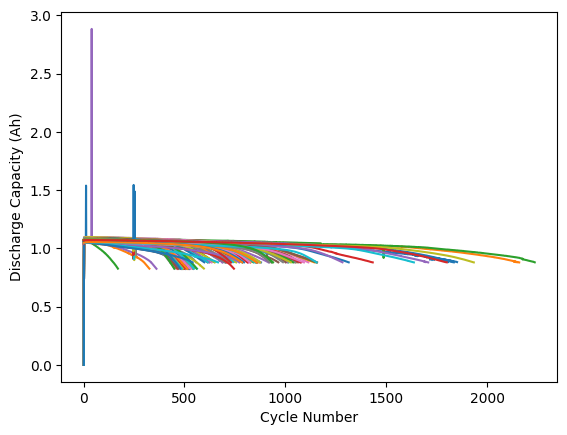

In [3]:
# Chargement des données : basées sur Load Data.ipynb

batch1 = pickle.load(open(r'./Data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']
numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'./Data/batch2.pkl','rb'))
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']
numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'./Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']
numBat3 = len(batch3.keys())

numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [4]:
# Quelles sont les clefs associées à chaque batterie ?
for bat_id, battery in bat_dict.items():
    print(battery.keys())
    break

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles', 'barcode'])


In [5]:
# Combien de batterie y a-t-il dans les 3 batchs réunis ?
print(f'bat_dict len: {len(bat_dict)}\n')
k1, v1 = list(bat_dict.items())[0]
print(f'k1: {k1}\n')
# Pour chaque batterie, on a les informations suivantes (et les types associés):
for k2, v2 in v1.items():
    print(f'k2: {k2}')
    print(f'v2 type: {type(v2)}')
    print()

bat_dict len: 124

k1: b1c0

k2: cycle_life
v2 type: <class 'numpy.ndarray'>

k2: charge_policy
v2 type: <class 'str'>

k2: summary
v2 type: <class 'dict'>

k2: cycles
v2 type: <class 'dict'>

k2: barcode
v2 type: <class 'numpy.ndarray'>



In [6]:
# Regardons le contenu de la première batterie
for bat_id, battery in bat_dict.items():
    print(f"Battery ID: {bat_id}") # identifiant
    print(f"Summary: {battery['summary']}") # résumé : un dictionnaire contenant des listes de même taille
    print(f"Cycle Life: {battery['cycle_life']}") # nombre de cycle de vie (+1 ici d'après nos observations)
    print(f"Cycles (len): {len(battery['cycles'])}") # Trop de données pour afficher
    print(f"Charge Policy: {battery['charge_policy']}") # politique de charge : C1(Q1)-C2
    break


Battery ID: b1c0
Summary: {'IR': array([0.        , 0.01674235, 0.01672431, ..., 0.0181332 , 0.0181233 ,
       0.0181211 ], shape=(1851,)), 'QC': array([0.        , 1.0710422 , 1.0716741 , ..., 0.88449496, 0.88432896,
       0.8840425 ], shape=(1851,)), 'QD': array([0.        , 1.0706892 , 1.0719005 , ..., 0.88462406, 0.88433141,
       0.88280821], shape=(1851,)), 'Tavg': array([ 0.        , 31.87501078, 31.93149033, ..., 32.70054223,
       32.99059246, 32.96182749], shape=(1851,)), 'Tmin': array([ 0.      , 29.56613 , 29.604385, ..., 30.243074, 30.337559,
       30.634762], shape=(1851,)), 'Tmax': array([ 0.      , 35.652016, 35.692978, ..., 36.786781, 36.923153,
       36.535774], shape=(1851,)), 'chargetime': array([ 0.        , 13.34125   , 13.42577667, ..., 17.04515833,
       17.15257333, 17.35889667], shape=(1851,)), 'cycle': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 1.849e+03, 1.850e+03,
       1.851e+03], shape=(1851,))}
Cycle Life: [[1852.]]
Cycles (len): 1851
Charge Po

In [7]:
# Vérifier que toutes les batteries ont les mêmes clés pour les champs summary et cycles

# Prendre la première batterie comme référence
reference_summary_keys = set(next(iter(bat_dict.values()))["summary"].keys())
reference_cycles_keys = set(next(iter(next(iter(bat_dict.values()))["cycles"].values())).keys())

# Vérifier les clés de chaque batterie
for bat_id, battery in bat_dict.items():
    # Vérification des clés de summary
    summary_keys = set(battery["summary"].keys())
    if summary_keys != reference_summary_keys:
        print(f"Mismatch in summary keys for battery {bat_id}")
        print(f"Expected keys: {reference_summary_keys}")
        print(f"Found keys: {summary_keys}")
    
    # Vérification des clés des cycles
    for cycle_id, cycle_data in battery["cycles"].items():
        cycle_keys = set(cycle_data.keys())
        if cycle_keys != reference_cycles_keys:
            print(f"Mismatch in cycle keys for battery {bat_id}, cycle {cycle_id}")
            print(f"Expected keys: {reference_cycles_keys}")
            print(f"Found keys: {cycle_keys}")

In [8]:
# Vérifier que les champs 'cycles' et cycles de summary (['summary']['cycle']) ont la même longueur pour chaque batterie
for bat_id, battery in bat_dict.items():
    if len(battery['summary']['cycle']) != len(battery['cycles']):
        print(f"Summary length mismatch for battery {bat_id}")

In [9]:
# Quelle est la différence entre 'cycle_life' et la longueur de 'summary' ?
for bat_id, battery in bat_dict.items():
    print(f"{battery['cycle_life'] - len(battery['summary']['cycle'])}")

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[-26.]]
[[-22.]]
[[-26.]]
[[-26.]]
[[-27.]]
[[-27.]]
[[-34.]]
[[-35.]]
[[-28.]]
[[-33.]]
[[-37.]]
[[-24.]]
[[-31.]]
[[-36.]]
[[-28.]]
[[-29.]]
[[-31.]]
[[-27.]]
[[-35.]]
[[-29.]]
[[-26.]]
[[-27.]]
[[-27.]]
[[-32.]]
[[-24.]]
[[-26.]]
[[-27.]]
[[-25.]]
[[-26.]]
[[-27.]]
[[-23.]]
[[-25.]]
[[-24.]]
[[-22.]]
[[-21.]]
[[-31.]]
[[-23.]]
[[-26.]]
[[-25.]]
[[-22.]]
[[-27.]]
[[-20.]]
[[-32.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]


TODO : différence de 1 dans la plupart des cas (au début et à la fin)
mais au milieu il y a de valeurs négatives...
on peut regarder si ça dépend des batch peut etre ?

In [10]:
# batch 1
for bat_id, battery in batch1.items():
    diff = battery['cycle_life'] - len(battery['summary']['cycle'])
    if diff != 1:
        print(f"{bat_id}: {diff}")

In [11]:
# batch 2
for bat_id, battery in batch2.items():
    diff = battery['cycle_life'] - len(battery['summary']['cycle'])
    if diff != 1:
        print(f"{bat_id}: {diff}")

b2c0: [[-26.]]
b2c1: [[-22.]]
b2c2: [[-26.]]
b2c3: [[-26.]]
b2c4: [[-27.]]
b2c5: [[-27.]]
b2c6: [[-34.]]
b2c10: [[-35.]]
b2c11: [[-28.]]
b2c12: [[-33.]]
b2c13: [[-37.]]
b2c14: [[-24.]]
b2c17: [[-31.]]
b2c18: [[-36.]]
b2c19: [[-28.]]
b2c20: [[-29.]]
b2c21: [[-31.]]
b2c22: [[-27.]]
b2c23: [[-35.]]
b2c24: [[-29.]]
b2c25: [[-26.]]
b2c26: [[-27.]]
b2c27: [[-27.]]
b2c28: [[-32.]]
b2c29: [[-24.]]
b2c30: [[-26.]]
b2c31: [[-27.]]
b2c32: [[-25.]]
b2c33: [[-26.]]
b2c34: [[-27.]]
b2c35: [[-23.]]
b2c36: [[-25.]]
b2c37: [[-24.]]
b2c38: [[-22.]]
b2c39: [[-21.]]
b2c40: [[-31.]]
b2c41: [[-23.]]
b2c42: [[-26.]]
b2c43: [[-25.]]
b2c44: [[-22.]]
b2c45: [[-27.]]
b2c46: [[-20.]]
b2c47: [[-32.]]


In [12]:
# batch 3
for bat_id, battery in batch3.items():
    diff = battery['cycle_life'] - len(battery['summary']['cycle'])
    if diff != 1:
        print(f"{bat_id}: {diff}")

TODO : c'est bien que dans le batch 2 que y a des erreurs
ducoup à voir dans la doc ? je sais pas trop 
est ce qu'on garde cette info ou pas ducoup 

la différence de 1 on l'explique par la doc 
"Cycle 1 data is not available in the struct. The sampling rate for this cycle was initially too high, so we excluded it from the data set to create more manageable file sizes."

faudrait voir pour le batch 2 
ducoup c'est le cycle_life qui contient moins de données que les données qu'on a dans summary (len cycle ... mais aussi des autres listes (on a bien vérifié que toutes les listes dans summary avaient la meme taille ))

TODO : essayer de trouver les infos suivantes=
- one step ou two steps policy
- charging time
- combien de cell tested par policy
- 75 nominal capacity (pour batch 2)
- 5 minutes rests
- C/10 cycle au début test (batch 2)
- cutoff currents
- pulse width
- 

3.6C(80%) and 4C(80%) policies have data that carry over from batch 1 (link on barcode). This applies to the cells in channels 1, 2, 3, 5, and 6. Please note that these are NOT new experiments, but a continuation of experiments from the 2017-05-12 batch.
-> jsp comment prendre ça en compte 

TODO : intégrer les notes liés aux différents batchs dans les données 

les données : 
description -> ça ok on a (sauf barcode et channel ducoup ...) à voir si on arrive à les extraire depuis mat 
    - charging policy 
    - cycle life
    - barcode : pas dispo dans données pkl (from github)
    - channel : pas dispo dans données pkl (from github)
    - 
summary -> ça oklm
    - basée sur données par cycle (des listes donc)
    - le numéro de cycle 
    - discharge capacity
    - charge capacity
    - internal resistance
    - maximum temperature
    - average temperature
    - minimum temperature
    - chargetime
cycle -> ça j'arrive pas à exploiter c'est une structure complexe : autant utiliser que le summary je pense
    - infos dans un cycle
        - time
        - charge capacity
        - current
        - voltage
        - temperature
        - discharge capacity


### Calcul du SOH : 
On doit intégrer le SOH
Q actuelle / Q nominale * 100
-> il faut qu'on trouve ces Q !
je pense que c'est le "discharge capacity" du summary (QD)
le Q nominale c'est donc le premier de discharge capacity 
pour SOC on utilise le charge capcity (QC)

Note : Une batterie est souvent considérée en fin de vie lorsqu'elle atteint 80% du SOH, ce qui correspond à 
QD = 80% de la capacité nominale initiale.

(on peut se baser sur l'article pour expliciter SOH et SOC)


essayons de retrouver les données summary  (enfaite faudrait lire aussi tout l'article mais tant que j'ai pas touché aux données je comprend rien)

objectif 1 
-> on construit un dataframe puis on ajoute les colonnes "calculées" et on drop tout ce qu'il faut dropper

TODO : y a les données SOC aussi ?? (la doc dit que c'est Q1 mais faudrait aussi vérifier par le calcul )

ajouter cette info : Internal resistance measurements were obtained during charging at 80% SOC by averaging 10 pulses of ±3.6C with a pulse width of 30 ms (2017-05-12 and 2017-06-30) or 33 ms (2018-04-12).

In [13]:
# Y a t il des clefs communes entre les différents batchs ?
batch1_keys = set(batch1.keys())
batch2_keys = set(batch2.keys())
batch3_keys = set(batch3.keys())
common_keys = batch1_keys.intersection(batch2_keys).intersection(batch3_keys)
print(f"Common keys: {common_keys}")

Common keys: set()


In [14]:
# Vérifier que toutes les données de summary ont la même longueur
for bat_id, battery in bat_dict.items():
    for key, value in battery['summary'].items():
        if len(value) != len(battery['cycles']):
            print(f"Summary data length mismatch for battery {bat_id}, key {key}")

In [15]:
# Quelle est la longueur de chaque batch ?
print(f'Len batch1: {len(batch1)}')
print(f'Len batch2: {len(batch2)}')
print(f'Len batch3: {len(batch3)}')

Len batch1: 41
Len batch2: 43
Len batch3: 40


In [16]:
# De quoi est composé le champ 'summary' ?
for bat_id, battery in bat_dict.items():
    for k,v in battery['summary'].items():
        print(f"{k}: {v}")
    break

IR: [0.         0.01674235 0.01672431 ... 0.0181332  0.0181233  0.0181211 ]
QC: [0.         1.0710422  1.0716741  ... 0.88449496 0.88432896 0.8840425 ]
QD: [0.         1.0706892  1.0719005  ... 0.88462406 0.88433141 0.88280821]
Tavg: [ 0.         31.87501078 31.93149033 ... 32.70054223 32.99059246
 32.96182749]
Tmin: [ 0.       29.56613  29.604385 ... 30.243074 30.337559 30.634762]
Tmax: [ 0.       35.652016 35.692978 ... 36.786781 36.923153 36.535774]
chargetime: [ 0.         13.34125    13.42577667 ... 17.04515833 17.15257333
 17.35889667]
cycle: [1.000e+00 2.000e+00 3.000e+00 ... 1.849e+03 1.850e+03 1.851e+03]


In [17]:
# Quelles sont les clefs et types de summary ?
for bat_id, battery in bat_dict.items():
    for k,v in battery['summary'].items():
        print(f"{k} \t :: len = {len(v)}, type = {type(v)}, array type = {v.dtype}")
    break

IR 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
QC 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
QD 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
Tavg 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
Tmin 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
Tmax 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
chargetime 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64
cycle 	 :: len = 1851, type = <class 'numpy.ndarray'>, array type = float64


summary  
    - le numéro de cycle (indicateur de l'ordre dans notre série temporelle) : `cycle`  
    - discharge capacity : `QD`  
    - charge capacity : `QC`  
    - internal resistance : `IR`  
    - maximum temperature : `Tmax`  
    - average temperature : `Tavg`  
    - minimum temperature : `Tmin`  
    - chargetime : `chargetime`  

## ICI JE CAPTE PAS LE CYCLES DUCOUP JE METS TOUT ENSEMBLE POUR PAS PERDRE MAIS JE PENSE OSEF 

In [18]:
# Quelles sont les clefs de cycles ?
for bat_id, battery in bat_dict.items():
    for k,v in battery['cycles'].items():
        print(f"{k} \t :: len = {len(v)}, type = {type(v)}")
    break

0 	 :: len = 9, type = <class 'dict'>
1 	 :: len = 9, type = <class 'dict'>
2 	 :: len = 9, type = <class 'dict'>
3 	 :: len = 9, type = <class 'dict'>
4 	 :: len = 9, type = <class 'dict'>
5 	 :: len = 9, type = <class 'dict'>
6 	 :: len = 9, type = <class 'dict'>
7 	 :: len = 9, type = <class 'dict'>
8 	 :: len = 9, type = <class 'dict'>
9 	 :: len = 9, type = <class 'dict'>
10 	 :: len = 9, type = <class 'dict'>
11 	 :: len = 9, type = <class 'dict'>
12 	 :: len = 9, type = <class 'dict'>
13 	 :: len = 9, type = <class 'dict'>
14 	 :: len = 9, type = <class 'dict'>
15 	 :: len = 9, type = <class 'dict'>
16 	 :: len = 9, type = <class 'dict'>
17 	 :: len = 9, type = <class 'dict'>
18 	 :: len = 9, type = <class 'dict'>
19 	 :: len = 9, type = <class 'dict'>
20 	 :: len = 9, type = <class 'dict'>
21 	 :: len = 9, type = <class 'dict'>
22 	 :: len = 9, type = <class 'dict'>
23 	 :: len = 9, type = <class 'dict'>
24 	 :: len = 9, type = <class 'dict'>
25 	 :: len = 9, type = <class 'dic

On veut former un dataframe 

Pour cela on va vérifier que le format de données soit le même pour tous les éléments dans bat_dict

In [19]:
stop = False
i = 1
for bat_id, battery in bat_dict.items():
    if not stop:
        print(f"Inspecting battery {bat_id}")
        i2 = 1
        for k,v in battery['cycles'].items():
            if i2 <= 4:
                print(f"{k} \t :: len = {len(v)}, type = {type(v)}")
                for k2, v2 in v.items():
                    print(f"\t{k2} \t :: len = {len(v2)}")
                    # print(f"\t{k2} \t :: len = {len(v2)}, type = {type(v2)} \t\t{v2}")
                i2 += 1
            else:
                break
        if i >= 4 : 
            stop = True
        i += 1
    # break

Inspecting battery b1c0
0 	 :: len = 9, type = <class 'dict'>
	I 	 :: len = 2
	Qc 	 :: len = 2
	Qd 	 :: len = 2
	Qdlin 	 :: len = 2
	T 	 :: len = 2
	Tdlin 	 :: len = 2
	V 	 :: len = 2
	dQdV 	 :: len = 2
	t 	 :: len = 2
1 	 :: len = 9, type = <class 'dict'>
	I 	 :: len = 1087
	Qc 	 :: len = 1087
	Qd 	 :: len = 1087
	Qdlin 	 :: len = 1000
	T 	 :: len = 1087
	Tdlin 	 :: len = 1000
	V 	 :: len = 1087
	dQdV 	 :: len = 1000
	t 	 :: len = 1087
2 	 :: len = 9, type = <class 'dict'>
	I 	 :: len = 1117
	Qc 	 :: len = 1117
	Qd 	 :: len = 1117
	Qdlin 	 :: len = 1000
	T 	 :: len = 1117
	Tdlin 	 :: len = 1000
	V 	 :: len = 1117
	dQdV 	 :: len = 1000
	t 	 :: len = 1117
3 	 :: len = 9, type = <class 'dict'>
	I 	 :: len = 1114
	Qc 	 :: len = 1114
	Qd 	 :: len = 1114
	Qdlin 	 :: len = 1000
	T 	 :: len = 1114
	Tdlin 	 :: len = 1000
	V 	 :: len = 1114
	dQdV 	 :: len = 1000
	t 	 :: len = 1114
Inspecting battery b1c1
0 	 :: len = 9, type = <class 'dict'>
	I 	 :: len = 2
	Qc 	 :: len = 2
	Qd 	 :: len = 2
	Qd

## FIN CYCLES PAS COMPRIS

In [20]:
# Est ce que la liste de cycle_life est toujours de longueur 1 ?
for bat_id, battery in bat_dict.items():
    if len(battery['cycle_life']) != 1:
        print(f"{bat_id}: {len(battery['cycle_life'])}")

In [21]:
# Remplacer la liste par juste la valeur de cycle_life (supprimer le ndarray de taille 1)
for bat_id, battery in bat_dict.items():
    battery['cycle_life'] = battery['cycle_life'][0][0]

In [22]:
# Vérifier que c'est bien maintenant un float
for bat_id, battery in bat_dict.items():
    if type(battery['cycle_life']) != np.float64:
        print(f"{bat_id}: {type(battery['cycle_life'])}")

In [23]:
# Vérifier que ce sont bien des ints cachés derrire les floats
for bat_id, battery in bat_dict.items():
    if battery['cycle_life'] != int(battery['cycle_life']):
        print(f"{bat_id}: {battery['cycle_life']}")

In [24]:
# Caster les cycle_life en int
for bat_id, battery in bat_dict.items():
    battery['cycle_life'] = int(battery['cycle_life'])

# Vérifier que ce sont bien des int maintenant
for bat_id, battery in bat_dict.items():
    if type(battery['cycle_life']) != int:
        print(f"{bat_id}: {type(battery['cycle_life'])}")

In [25]:
# Vérifier la structure de chaque batterie (type, clef des sous dict...)
for bat_id, battery in bat_dict.items():
    # Vérifier que les clés attendues existent
    if 'summary' not in battery or 'cycle_life' not in battery or 'cycles' not in battery or 'charge_policy' not in battery:
        print(f"Missing key in battery {bat_id}")

    # Vérifier que les clés de summary sont bien présentes
    for k in ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle']:
        if k not in battery['summary']:
            print(f"Missing key {k} in summary of battery {bat_id}")

    # Vérifier le format de cycle life
    if type(battery['cycle_life']) != int:
        print(f"Unexpected format for cycle_life in battery {bat_id}, type : {type(battery['cycle_life'])}")

    # Vérifier le type de charge policy
    if type(battery['charge_policy']) != str:
        print(f"Charge policy is not a string in battery {bat_id}")

In [26]:
# Vérifier que pour chaque ['summary']['cycle'] la liste est bien toujours un range de 1 à n (et +1 entre chaque cycle)
for bat_id, battery in bat_dict.items():
    cycle_range = range(1, len(battery['summary']['cycle'])+1)
    if not np.array_equal(battery['summary']['cycle'], np.array(cycle_range)):
        print(f"Cycle range mismatch for battery {bat_id}")

### Former un Dataframe

In [27]:
df = pd.DataFrame(bat_dict)
df = df.transpose() # Transpose pour avoir les batteries en index
df = df.reset_index() 
df = df.rename(columns={'index': 'battery_id'})
df.head()

,battery_id,cycle_life,charge_policy,summary,cycles,barcode
0,b1c0,1852,3.6C(80%)-3.6C,"{'IR': [0.0, 0.016742354, 0.016724309, 0.01668...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","[[3707764736, 2, 1, 1, 1, 1]]"
1,b1c1,2160,3.6C(80%)-3.6C,"{'IR': [0.0, 0.017038831, 0.017009802, 0.01692...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","[[3707764736, 2, 1, 1, 2, 1]]"
2,b1c2,2237,3.6C(80%)-3.6C,"{'IR': [0.0, 0.01686798, 0.016831938, 0.016718...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","[[3707764736, 2, 1, 1, 3, 1]]"
3,b1c3,1434,4C(80%)-4C,"{'IR': [0.0, 0.016369704, 0.016315572, 0.01632...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","[[3707764736, 2, 1, 1, 4, 1]]"
4,b1c4,1709,4C(80%)-4C,"{'IR': [0.0, 0.016787428, 0.016740341, 0.01673...","{'0': {'I': [0, 0], 'Qc': [0, 0], 'Qd': [0, 0]...","[[3707764736, 2, 1, 1, 5, 1]]"


In [28]:
# Supprimer cycles
df.drop(columns=['cycles'], inplace=True)
df.head()

,battery_id,cycle_life,charge_policy,summary,barcode
0,b1c0,1852,3.6C(80%)-3.6C,"{'IR': [0.0, 0.016742354, 0.016724309, 0.01668...","[[3707764736, 2, 1, 1, 1, 1]]"
1,b1c1,2160,3.6C(80%)-3.6C,"{'IR': [0.0, 0.017038831, 0.017009802, 0.01692...","[[3707764736, 2, 1, 1, 2, 1]]"
2,b1c2,2237,3.6C(80%)-3.6C,"{'IR': [0.0, 0.01686798, 0.016831938, 0.016718...","[[3707764736, 2, 1, 1, 3, 1]]"
3,b1c3,1434,4C(80%)-4C,"{'IR': [0.0, 0.016369704, 0.016315572, 0.01632...","[[3707764736, 2, 1, 1, 4, 1]]"
4,b1c4,1709,4C(80%)-4C,"{'IR': [0.0, 0.016787428, 0.016740341, 0.01673...","[[3707764736, 2, 1, 1, 5, 1]]"


In [29]:
# Extraire C1(Q1)-C2 pour chaque charge_policy et ajouter les colonnes dans le dataframe
# si ça matche pas -> print

pattern = r"(?P<C1>[0-9.]+)C\((?P<Q1>[0-9]+)%\)-(?P<C2>[0-9.]+)C?"

def extract_c1_q1_c2(row):
    match = re.match(pattern, row)
    if match:
        return match.group('C1'), match.group('Q1'), match.group('C2')
    else:
        print(row)
        return None, None, None
    
df[['C1', 'Q1', 'C2']] = df['charge_policy'].apply(extract_c1_q1_c2).apply(pd.Series)

mismatches = df[df['C1'].isna()]
print(f'Mismatches: {mismatches}')

Mismatches: Empty DataFrame
Columns: [battery_id, cycle_life, charge_policy, summary, barcode, C1, Q1, C2]
Index: []


In [30]:
df[['C1', 'Q1', 'C2', 'charge_policy']].head()

,C1,Q1,C2,charge_policy
0,3.6,80,3.6,3.6C(80%)-3.6C
1,3.6,80,3.6,3.6C(80%)-3.6C
2,3.6,80,3.6,3.6C(80%)-3.6C
3,4,80,4,4C(80%)-4C
4,4,80,4,4C(80%)-4C


In [31]:
df['C1'].unique() # TODO : min max ? doc à voir

array(['3.6', '4', '4.4', '4.8', '5.4', '6', '7', '8', '1', '2', '4.65',
       '4.9', '5.2', '5.6', '5', '5.3', '3.7', '5.9'], dtype=object)

In [32]:
df['C2'].unique() # TODO : min max ? doc à voir 

array(['3.6', '4', '4.4', '4.8', '3', '5.4', '6', '5', '5.5', '4.85',
       '4.75', '4.5', '4.25', '3.5', '4.3', '4.6', '5.9', '3.1'],
      dtype=object)

In [33]:
df['Q1'].unique() # doc à voir si données bien dans les limites attendues

array(['80', '40', '50', '60', '70', '30', '15', '25', '35', '4', '10',
       '2', '7', '22', '9', '13', '31', '24', '47', '55', '8', '19', '44',
       '69', '27', '61', '37', '58', '66', '71', '38', '5', '65', '20',
       '52', '67', '54', '36'], dtype=object)

In [34]:
# Supprimer la colonne charge_policy maintenant qu'on a extrait les informations
df = df.drop(columns=['charge_policy'])

In [35]:
# Convertir C1 et C2 en float et Q1 en int
df['C1'] = df['C1'].astype(float)
df['C2'] = df['C2'].astype(float)
df['Q1'] = df['Q1'].astype(int)

In [36]:
# Extraire la provenance du batch (pour par la suite pouvoir ajouter les données de la documentation)

# battery_id = 'b1c0' (batch 1 , cell 0)
pattern = r"b(?P<batch>[0-9]+)c(?P<chanel>[0-9]+)"

def extract_batch_chanel_ids(row):
    match = re.match(pattern, row)
    if match:
        return match.group('batch'), match.group('chanel')
    else:
        print(row)
        return None, None
    
df[['batch', 'chanel']] = df['battery_id'].apply(extract_batch_chanel_ids).apply(pd.Series)

mismatches = df[df['batch'].isna()]
print(f'Mismatches: {mismatches}')

Mismatches: Empty DataFrame
Columns: [battery_id, cycle_life, summary, barcode, C1, Q1, C2, batch, chanel]
Index: []


In [37]:
df['batch'].unique()

array(['1', '2', '3'], dtype=object)

In [38]:
df['chanel'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '9', '11', '14', '15',
       '16', '17', '18', '19', '20', '21', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45', '10', '12', '13', '22',
       '46', '47', '8'], dtype=object)

In [39]:
# Afficher les chanels de batch 1
df[df['batch'] == '1']['chanel'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '9', '11', '14', '15',
       '16', '17', '18', '19', '20', '21', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45'], dtype=object)

In [40]:
# Afficher les chanels de batch 2
df[df['batch'] == '2']['chanel'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '10', '11', '12', '13', '14',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45', '46', '47'], dtype=object)

In [41]:
# Afficher les chanels de batch 3
df[df['batch'] == '3']['chanel'].unique()

array(['0', '1', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24',
       '25', '26', '27', '28', '29', '30', '31', '33', '34', '35', '36',
       '38', '39', '40', '41', '44', '45'], dtype=object)

In [42]:
df = df.drop(columns=['battery_id'])

This applies to the cells in channels 1, 2, 3, 5, and 6. Please note that these are NOT new experiments, but a continuation of experiments from the 2017-05-12 batch.

TODO ;: je me demande si on ferait pas bien de les drop ducoup 
ou alors si avec matlab on peut choper le barcode ...
(on a accès à matlab gratos avec unistra pour voir si on peut le choper)

sinon ça veut juste dire que le QD initial doit se rebaser sur l'ancien (et on ajoute une colonne sur le fait qu'il y a eu une pause peut etre ?)

In [43]:
# Récupérer le barcode
df['barcode']

0       [[3707764736, 2, 1, 1, 1, 1]]
1       [[3707764736, 2, 1, 1, 2, 1]]
2       [[3707764736, 2, 1, 1, 3, 1]]
3       [[3707764736, 2, 1, 1, 4, 1]]
4       [[3707764736, 2, 1, 1, 5, 1]]
                    ...              
119    [[3707764736, 2, 1, 1, 40, 1]]
120    [[3707764736, 2, 1, 1, 41, 1]]
121    [[3707764736, 2, 1, 1, 42, 1]]
122    [[3707764736, 2, 1, 1, 45, 1]]
123    [[3707764736, 2, 1, 1, 46, 1]]
Name: barcode, Length: 124, dtype: object

In [44]:
# Découper les données de barcode en 6 colonnes différentes pour étudier les différences

def split_barcode(row):
    return [row[0][i] for i in range(6)]

df[['barcode1', 'barcode2', 'barcode3', 'barcode4', 'barcode5', 'barcode6']] = df['barcode'].apply(split_barcode).apply(pd.Series)

In [45]:
print(df['barcode1'].unique())
print("-"*10)
print(df['barcode2'].unique())
print("-"*10)
print(df['barcode3'].unique())
print("-"*10)
print(df['barcode4'].unique())
print("-"*10)
print(df['barcode6'].unique())


[3707764736]
----------
[2]
----------
[1]
----------
[1]
----------
[1]


In [46]:
print(df['barcode5'].unique())

[ 1  2  3  4  5  6  7  8 10 12 15 16 17 18 19 20 21 22 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 11 13 14 23 47 48  9]


In [47]:
# Supprimer les colonnes barcode 1, 2, 3, 4 et 6 car elles n'ont qu'une seule valeur
df = df.drop(columns=['barcode1'])
df = df.drop(columns=['barcode2'])
df = df.drop(columns=['barcode3'])
df = df.drop(columns=['barcode4'])
df = df.drop(columns=['barcode6'])
df = df.drop(columns=['barcode'])

In [48]:
# Relation entre les colonnes barcode5 et chanel
df[['barcode5', 'chanel']]

,barcode5,chanel
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
119,40,39
120,41,40
121,42,41
122,45,44


In [49]:
# Y a t il juste une relation de -1 entre les deux colonnes ?
# si différent de 1 -> print
df['barcode5'] = df['barcode5'].astype(int)
df['chanel'] = df['chanel'].astype(int)

df['diff'] = df['barcode5'] - df['chanel']
df['diff'].unique()

array([1])

In [50]:
# On supprime donc la colonne barcode5
df = df.drop(columns=['barcode5'])
df = df.drop(columns=['diff'])

In [51]:
# TODO : je ne comprends pas comment on doit savoir ducoup si c'est la meme expérience qui a continué entre le batch 1 et le batch 2
# pour l'instant je propose qu'on supprime donc juste cette donnée
# on essaiera de trouver une solution plus tard : le Qnominale doit etre basée sur le batch1 et on doit prendre en compte le fait qu'il y a eu une pause ?
df = df.drop(columns=['chanel'])

In [52]:
# TODO : supprimer l'origine du batch, ce qu'on veut ces les données liées par le batch à la ligne mais pas le numéro du batch en lui même

In [53]:
df.head()

,cycle_life,summary,C1,Q1,C2,batch
0,1852,"{'IR': [0.0, 0.016742354, 0.016724309, 0.01668...",3.6,80,3.6,1
1,2160,"{'IR': [0.0, 0.017038831, 0.017009802, 0.01692...",3.6,80,3.6,1
2,2237,"{'IR': [0.0, 0.01686798, 0.016831938, 0.016718...",3.6,80,3.6,1
3,1434,"{'IR': [0.0, 0.016369704, 0.016315572, 0.01632...",4.0,80,4.0,1
4,1709,"{'IR': [0.0, 0.016787428, 0.016740341, 0.01673...",4.0,80,4.0,1


In [54]:
df.dtypes

cycle_life     object
summary        object
C1            float64
Q1              int64
C2            float64
batch          object
dtype: object

In [55]:
# cycle_life -> int
df['cycle_life'] = df['cycle_life'].astype(int)

In [56]:
# Créer un id unique pour chaque ligne dans notre dataframe pour pouvoir pivoter les données contenu dans summary sans perdre les données liées à la batterie
df['id'] = df.index

In [57]:
# Extraire le Qnominale : prendre le [summary][QD][0]
df['QD1'] = df['summary'].apply(lambda x: x['QD'][0])

In [58]:
df['QD1'].unique()

array([0.       , 1.0680572, 1.06918  , 1.0708591, 1.0638535, 1.0692153,
       1.0641999, 1.0651802, 1.0651031, 1.0680432, 1.0676208, 1.076097 ,
       1.0742625, 1.0648884, 1.0610169, 1.0454259, 1.0786781, 1.0718927,
       1.0757267, 1.0713947, 1.0639789, 1.0640887, 1.0733846, 1.0623763,
       1.0682162, 1.0699197, 1.0634685, 1.0695118, 1.0712117, 1.0758885,
       1.0649502, 1.0651143, 1.0753652, 1.0712371, 1.0661006, 1.0743777,
       1.0735563, 1.0648384, 1.074605 , 1.0691837, 1.0664769, 1.0661633,
       1.0683196, 1.0383378, 1.0665728, 1.0642239, 1.0622736, 1.0717411,
       1.0500579, 1.0620248, 1.0664694, 1.0636606, 1.0683683, 1.0608749,
       1.0673251, 1.0731678, 1.0642039, 1.0716274, 1.0677625, 1.0605524,
       1.0653081, 1.0674672, 1.0706265, 1.063777 , 1.0678786, 1.0551282,
       1.0451531, 1.0600799, 1.0709693, 1.0592589, 1.0512739, 1.0652004,
       1.0674757, 1.0674968, 1.0594152, 1.0602307, 1.0626153, 1.0573761,
       1.0691597, 1.0464231, 1.0581568, 1.0491925, 

In [59]:
# On aperçoit un 0 : cela n'est pas normal, on sauve donc aussi le QD2 pour pouvoir le remplacer

In [60]:
df['QD2'] = df['summary'].apply(lambda x: x['QD'][1])
df['QD2'].unique()

array([1.0706892, 1.0753012, 1.0799223, 1.0797229, 1.0784167, 1.0761266,
       1.0758358, 1.0938644, 1.0829742, 1.0537786, 1.0709661, 1.0611236,
       1.0811664, 1.072052 , 1.0661705, 1.0851147, 1.07263  , 1.0824388,
       1.0792934, 1.0745355, 1.0752345, 1.0876514, 1.0790461, 1.0777475,
       1.0794537, 1.0798637, 1.0946392, 1.0778366, 1.0924908, 1.0766174,
       1.0707464, 1.0778315, 1.0748194, 1.0729513, 1.0817773, 1.0833029,
       1.0789614, 1.0798725, 1.0682389, 1.0847682, 1.0839558, 1.0700541,
       1.0720705, 1.0735391, 1.0668509, 1.0728973, 1.0680153, 1.0687391,
       1.0690521, 1.0717047, 1.0712759, 1.080285 , 1.0780684, 1.0656468,
       1.063838 , 1.0480373, 1.0831043, 1.0768799, 1.079723 , 1.0745209,
       1.0679682, 1.0672674, 1.0766411, 1.065841 , 1.07155  , 1.0725043,
       1.0672802, 1.0732793, 1.0742669, 1.079052 , 1.0688509, 1.0687217,
       1.079731 , 1.0748166, 1.0699497, 1.0784613, 1.0765519, 1.0682049,
       1.0780239, 1.0735646, 1.070887 , 1.0704726, 

In [61]:
summary_expanded = df['summary'].apply(pd.Series)
summary_expanded['id'] = df['id']
summary_expanded['cycle_life'] = df['cycle_life']
summary_expanded['QD1'] = df['QD1']
summary_expanded['QD2'] = df['QD2']
summary_expanded['C1'] = df['C1']
summary_expanded['Q1'] = df['Q1']
summary_expanded['C2'] = df['C2']
summary_expanded['batch'] = df['batch']
summary_expanded.head()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,id,cycle_life,QD1,QD2,C1,Q1,C2,batch
0,"[0.0, 0.016742354, 0.016724309, 0.016681245, 0...","[0.0, 1.0710422, 1.0716741, 1.0723044, 1.07297...","[0.0, 1.0706892, 1.0719005, 1.0725095, 1.07317...","[0.0, 31.875010776448963, 31.931490327663376, ...","[0.0, 29.56613, 29.604385, 29.744202, 29.64470...","[0.0, 35.652016, 35.692978, 35.680588, 35.7286...","[0.0, 13.341250000000006, 13.42577666666666, 1...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",0,1852,0.0,1.070689,3.6,80,3.6,1
1,"[0.0, 0.017038831, 0.017009802, 0.016928403, 0...","[0.0, 1.0750588, 1.0764499, 1.0771132, 1.07775...","[0.0, 1.0753012, 1.0766124, 1.0772982, 1.07815...","[0.0, 31.668844081576545, 31.722739939231452, ...","[0.0, 29.853098, 29.857759, 30.133654, 29.9605...","[0.0, 34.307796, 34.418705, 34.707664, 34.5954...","[0.0, 13.426056666666652, 13.341520000000006, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",1,2160,0.0,1.075301,3.6,80,3.6,1
2,"[0.0, 0.01686798, 0.016831938, 0.01671898, 0.0...","[0.0, 1.0797698, 1.0811372, 1.0819083, 1.08250...","[0.0, 1.0799223, 1.0813154, 1.082234, 1.082731...","[0.0, 31.82541973754445, 31.875471250889714, 3...","[0.0, 29.983988, 30.001017, 30.300148, 30.0331...","[0.0, 34.703838, 34.788918, 35.098438, 34.9782...","[0.0, 13.34142166666667, 13.341461666666662, 1...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",2,2237,0.0,1.079922,3.6,80,3.6,1
3,"[0.0, 0.016369704, 0.016315572, 0.016325498, 0...","[0.0, 1.0793147, 1.0806946, 1.0815663, 1.08224...","[0.0, 1.0797229, 1.0812283, 1.0819938, 1.08273...","[0.0, 30.245592437098356, 30.313372000000026, ...","[0.0, 29.596653, 29.836266, 29.724728, 29.9965...","[0.0, 30.935932, 31.18433, 30.779972, 31.10115...","[0.0, 12.008575000000018, 12.008094999999988, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",3,1434,0.0,1.079723,4.0,80,4.0,1
4,"[0.0, 0.016787428, 0.016740341, 0.016738746, 0...","[0.0, 1.078509, 1.0789363, 1.0796522, 1.080269...","[0.0, 1.0784167, 1.0790124, 1.0797466, 1.08042...","[0.0, 31.659106455331386, 31.682169403151168, ...","[0.0, 29.640825, 29.737724, 29.74818, 29.84008...","[0.0, 34.610603, 34.632095, 34.424313, 34.5436...","[0.0, 12.008310000000014, 12.092648333333333, ...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",4,1709,0.0,1.078417,4.0,80,4.0,1


In [62]:
result = summary_expanded.apply(lambda row : pd.DataFrame({
    "id" : row["id"],
    "cycle_life" : row["cycle_life"],
    "C1": row["C1"],
    "C2": row["C2"],
    "Q1": row["Q1"],
    "batch": row["batch"],
    "QD1": row["QD1"],
    "QD2": row["QD2"],
    
    "cycle" : row["cycle"],
    "IR" : row["IR"],
    "QC" : row["QC"],
    "QD" : row["QD"],
    "Tavg" : row["Tavg"],
    "Tmin" : row["Tmin"],
    "Tmax" : row["Tmax"],
    "chargetime" : row["chargetime"],
}), axis=1)

In [63]:
result[0]

,id,cycle_life,C1,C2,Q1,batch,QD1,QD2,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime
0,0,1852,3.6,3.6,80,1,0.0,1.070689,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1852,3.6,3.6,80,1,0.0,1.070689,2.0,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250
2,0,1852,3.6,3.6,80,1,0.0,1.070689,3.0,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777
3,0,1852,3.6,3.6,80,1,0.0,1.070689,4.0,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167
4,0,1852,3.6,3.6,80,1,0.0,1.070689,5.0,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,0,1852,3.6,3.6,80,1,0.0,1.070689,1847.0,0.018263,0.885568,0.885435,32.432079,31.080084,35.415527,17.025530
1847,0,1852,3.6,3.6,80,1,0.0,1.070689,1848.0,0.018619,0.884639,0.884546,31.683310,28.951157,36.136974,17.025530
1848,0,1852,3.6,3.6,80,1,0.0,1.070689,1849.0,0.018133,0.884495,0.884624,32.700542,30.243074,36.786781,17.045158
1849,0,1852,3.6,3.6,80,1,0.0,1.070689,1850.0,0.018123,0.884329,0.884331,32.990592,30.337559,36.923153,17.152573


In [64]:
result[123]

,id,cycle_life,C1,C2,Q1,batch,QD1,QD2,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime
0,123,1801,4.8,4.8,80,3,1.068802,1.069549,1.0,0.015778,1.068454,1.068802,32.615140,30.800251,34.506973,11.037985
1,123,1801,4.8,4.8,80,3,1.068802,1.069549,2.0,0.015742,1.069192,1.069549,32.583423,30.786549,34.443512,11.039718
2,123,1801,4.8,4.8,80,3,1.068802,1.069549,3.0,0.015712,1.069926,1.070114,32.589319,30.680435,34.548187,11.037380
3,123,1801,4.8,4.8,80,3,1.068802,1.069549,4.0,0.015698,1.070196,1.070422,32.572895,30.635644,34.512981,11.037245
4,123,1801,4.8,4.8,80,3,1.068802,1.069549,5.0,0.015679,1.070442,1.070618,32.536870,30.620083,34.481216,11.036160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,123,1801,4.8,4.8,80,3,1.068802,1.069549,1796.0,0.017538,0.881796,0.881539,32.532753,30.328932,34.571934,15.404138
1796,123,1801,4.8,4.8,80,3,1.068802,1.069549,1797.0,0.017294,0.881874,0.881441,32.679857,29.591684,35.492989,15.497987
1797,123,1801,4.8,4.8,80,3,1.068802,1.069549,1798.0,0.017605,0.881364,0.880883,32.217071,31.470758,33.999550,16.357937
1798,123,1801,4.8,4.8,80,3,1.068802,1.069549,1799.0,0.017526,0.881120,0.880757,33.035630,29.526152,35.779078,16.046140


In [65]:
# Vérifier que pour chaque élément de result il y a une valeur unique pour tous les éléments de ['id', 'cycle_life', 'C1', 'C2', 'Q1', 'batch', 'QD0', 'QD1']

for i in range(len(result)):
    df = result[i]
    unique_values = df[['id', 'cycle_life', 'C1', 'C2', 'Q1', 'batch', 'QD1', 'QD2']].nunique()
    if not all(unique_values == 1):
        print(f"Mismatch in element {i}:")
        print(unique_values)

In [66]:
pivot_df = pd.concat(result.values)
pivot_df.head()

,id,cycle_life,C1,C2,Q1,batch,QD1,QD2,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime
0,0,1852,3.6,3.6,80,1,0.0,1.070689,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1852,3.6,3.6,80,1,0.0,1.070689,2.0,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250
2,0,1852,3.6,3.6,80,1,0.0,1.070689,3.0,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777
3,0,1852,3.6,3.6,80,1,0.0,1.070689,4.0,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167
4,0,1852,3.6,3.6,80,1,0.0,1.070689,5.0,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442


In [67]:
df = pivot_df

In [68]:
# Filtrer les lignes où 'cycle' = 1 pour extraire QD
df_qd1 = df[df['cycle'] == 1][['id', 'QD']]
# Renommer la colonne 'QD' en 'QD1bis' pour la joindre plus facilement
df_qd1 = df_qd1.rename(columns={'QD': 'QD1bis'})

# Joindre les DataFrames avec le DataFrame d'origine sur la colonne 'id'
df = pd.merge(df, df_qd1, on='id', how='left')

df.head()


,id,cycle_life,C1,C2,Q1,batch,QD1,QD2,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,QD1bis
0,0,1852,3.6,3.6,80,1,0.0,1.070689,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0,1852,3.6,3.6,80,1,0.0,1.070689,2.0,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,0.0
2,0,1852,3.6,3.6,80,1,0.0,1.070689,3.0,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,0.0
3,0,1852,3.6,3.6,80,1,0.0,1.070689,4.0,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,0.0
4,0,1852,3.6,3.6,80,1,0.0,1.070689,5.0,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,0.0


In [69]:
# Filtrer les lignes où 'cycle' = 2 pour extraire QD
df_qd2 = df[df['cycle'] == 2][['id', 'QD']]

# Renommer la colonne 'QD' en 'QD2bis' pour la joindre plus facilement
df_qd2 = df_qd2.rename(columns={'QD': 'QD2bis'})

# Joindre les DataFrames avec le DataFrame d'origine sur la colonne 'id'
df = pd.merge(df, df_qd2, on='id', how='left')

df.head()

,id,cycle_life,C1,C2,Q1,batch,QD1,QD2,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,QD1bis,QD2bis
0,0,1852,3.6,3.6,80,1,0.0,1.070689,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.070689
1,0,1852,3.6,3.6,80,1,0.0,1.070689,2.0,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,0.0,1.070689
2,0,1852,3.6,3.6,80,1,0.0,1.070689,3.0,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,0.0,1.070689
3,0,1852,3.6,3.6,80,1,0.0,1.070689,4.0,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,0.0,1.070689
4,0,1852,3.6,3.6,80,1,0.0,1.070689,5.0,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,0.0,1.070689


In [70]:
# Vérifier si QD1 et QD1bis sont identiques
identical = (df['QD1'] == df['QD1bis']).all()
print(f"QD1 and QD1bis are identical: {identical}")

QD1 and QD1bis are identical: True


In [71]:
identical = (df['QD2'] == df['QD2bis']).all()
print(f"QD2 and QD2bis are identical: {identical}")

QD2 and QD2bis are identical: True


In [72]:
# On drop donc les "bis" : on a bien reconstruit les colonnes QD1 et QD2
df = df.drop(columns=['QD1bis'])
df = df.drop(columns=['QD2bis'])

In [73]:
# On ne peut pas accepter que Qnominale soit 0

# Vérifions que quand QD1 = 0, cycle = 1 alors IR, QC, QD, Tavg, Tmin, Tmax, chargetime = 0
df[(df['QD1'] == 0) & (df['cycle'] == 1)][['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']].nunique()

IR            1
QC            1
QD            1
Tavg          1
Tmin          1
Tmax          1
chargetime    1
dtype: int64

In [74]:
# Voir les valeurs quand QD1 = 0 et cycle = 1
df[(df['QD1'] == 0) & (df['cycle'] == 1)][['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']].head(1)

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# C'est bon tout est à zéro -> on va supprimer ces lignes
df = df.drop(df[(df['QD1'] == 0) & (df['cycle'] == 1)].index)

# Récapitulons : on veut créer la colonne Qnominale
# si QD1 = 0 alors Qnominale = QD2 
# sinon Qnominale = QD1

# On va donc créer une colonne Qnominale
df['Qnominale'] = df['QD1']
df.loc[df['QD1'] == 0, 'Qnominale'] = df['QD2']
df = df.drop(columns=['QD1'])
df = df.drop(columns=['QD2'])

df.head()

,id,cycle_life,C1,C2,Q1,batch,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,Qnominale
1,0,1852,3.6,3.6,80,1,2.0,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,1.070689
2,0,1852,3.6,3.6,80,1,3.0,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,1.070689
3,0,1852,3.6,3.6,80,1,4.0,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,1.070689
4,0,1852,3.6,3.6,80,1,5.0,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,1.070689
5,0,1852,3.6,3.6,80,1,6.0,0.016623,1.073491,1.073576,31.961062,29.752932,35.711758,13.340835,1.070689


In [ ]:
# TODO : vérifier en extrayant deux id : un où il y a avait des 0 en cycle = 1, et l'autre non
# est ce qu'on obtient bien ce qu'il faut ?

In [77]:
# Convertir cycle en int
df['cycle'] = df['cycle'].astype(int)

In [79]:
# On peut donc maintenant calculer le SOH : QD / Qnominale * 100 
df['SOH'] = (df['QD'] / df['Qnominale']) * 100
df.head()

,id,cycle_life,C1,C2,Q1,batch,cycle,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,Qnominale,SOH
1,0,1852,3.6,3.6,80,1,2,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,1.070689,100.000000
2,0,1852,3.6,3.6,80,1,3,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,1.070689,100.113133
3,0,1852,3.6,3.6,80,1,4,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,1.070689,100.170012
4,0,1852,3.6,3.6,80,1,5,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,1.070689,100.232075
5,0,1852,3.6,3.6,80,1,6,0.016623,1.073491,1.073576,31.961062,29.752932,35.711758,13.340835,1.070689,100.269630


In [82]:
# Affcher valeurs statistiques liées à SOH
df['SOH'].describe()

count    100460.000000
mean         96.411939
std           4.821813
min          76.646759
25%          94.968482
50%          98.250525
75%          99.803933
max         270.508751
Name: SOH, dtype: float64

In [ ]:
# TODO : on obtient des valeurs > 100 % -> à voir si c'est normal ou pas

### Analyse exploratoire 
### Préparation des données

In [54]:
# corriger erreurs de temps qui se réinit à zéro en milieu de cycle 

In [55]:
# visualiser évolution 
# calcul du SOH si nécessaire
# transformation : valeurs maquantes (interpolation ou imputation), normalisation...

In [56]:
# Ajouter des variables telles que :
# Température moyenne par cycle.
# Résistance interne.
# Taux de charge et décharge.
# Extraire les informations des politiques de charge rapide (“C1(Q1)-C2”).

In [57]:
# split train test

## 3. Modélisation 
### Modèle 1 : 
### Modèle 2 : 
### Modèle 3 : 

In [58]:
# Modèles basiques : Régression linéaire, Random Forest.
# Modèles avancés : Réseaux de neurones récurrents (RNN, LSTM, GRU).

# Régression linéaire : Point de départ pour comprendre la relation linéaire.
# Random Forest : Modèle robuste pour capturer les non-linéarités.
# RNN / LSTM : Adapter pour les données séquentielles, avec gestion des fenêtres temporelles.

# Comparer les résultats avec des métriques :
# RMSE : Erreur quadratique moyenne.
# MAE : Erreur absolue moyenne.
# R² : Coefficient de détermination.

## 4. Comparaison des métriques pour évaluer la performance des différents modèles

In [59]:
# Optimisation : 
# Ajuster les hyperparamètres des modèles pour améliorer les performances (Grid Search, Random Search).
# Analyser les temps de calcul et optimiser le code si nécessaire.

## 5. Explicabilité
### Application des outils d'explicabilité
### Discussion des résultats

## 6. Conclusion
### Résumé des performances des modèles
### Interprétation des résultats d'explicabilité
### Perspectives : comment utiliser les résultats pour guider la maintenance et l’optimisation des batteries